In [ ]:
import pandas as pd
import requests
import os
import time
import re

In [ ]:
# CONFIGURATION & CONSTANTS

GOOGLE_API_KEY = "GOOGLE_API_KEY"

# Directory paths (Update these paths to match your Kaggle/Local environment)
RAW_DATA_DIR = r"../../data/01_raw_data/01_store_locations"
PROCESSED_DATA_PATH = r"../../data/02_processed_data/01_store_locations/CannabisStoreLocations.csv"

# Mapping abbreviation to full name for address construction
PROVINCE_FULL_NAMES = {
    "AB": "Alberta",
    "BC": "British Columbia",
    "MB": "Manitoba",
    "NB": "New Brunswick",
    "NL": "Newfoundland and Labrador",
    "NS": "Nova Scotia",
    "NT": "Northwest Territories",
    "NU": "Nunavut",
    "ON": "Ontario",
    "PE": "Prince Edward Island",
    "QC": "Quebec",
    "SK": "Saskatchewan",
    "YT": "Yukon"
}

In [3]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def get_geodata(address):
    """
    Queries the Google Maps Geocoding API.
    
    Args:
        address (str): The full address string to geocode.
        
    Returns:
        tuple: (latitude, longitude, postal_code)
    """
    if not address or not isinstance(address, str):
        return None, None, None
        
    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": address, "key": GOOGLE_API_KEY}

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if data["status"] == "OK":
            result = data["results"][0]
            location = result["geometry"]["location"]
            lat = location["lat"]
            lng = location["lng"]

            # Attempt to extract specific postal code from address components
            postal_code = None
            for component in result["address_components"]:
                if "postal_code" in component["types"]:
                    postal_code = component["long_name"]
                    break
            
            return lat, lng, postal_code
    except Exception as e:
        print(f"Error geocoding {address}: {e}")

    return None, None, None

def clean_bc_address_string(full_address, city, province):
    """
    Specific cleaning logic for British Columbia data where the address field 
    often contains the City and Province redundantly.
    """
    if not isinstance(full_address, str):
        return full_address, None

    # Regex to find Canadian Postal Codes (A1A 1A1 or A1A1A1)
    postal_code_pattern = r"[A-Za-z]\d[A-Za-z]\s?\d[A-Za-z]\d"
    postal_match = re.search(postal_code_pattern, full_address)
    postal_code = postal_match.group(0) if postal_match else None

    # clean the address string by removing city, province, and postal code from the tail
    cleaned = full_address
    # Create a regex pattern to strip the suffix details
    remove_pattern = rf",\s*{re.escape(str(city))}\s*,?\s*{str(province)}\s*{str(postal_code) if postal_code else ''}"
    cleaned = re.sub(remove_pattern, "", cleaned, flags=re.IGNORECASE)
    
    return cleaned.strip(), postal_code

In [4]:
def process_province_data(file_name, province_code, file_type, col_mapping):
    # ... [Header and Load Data logic remains the same] ...
    file_path = os.path.join(RAW_DATA_DIR, file_name)
    print(f"--- Processing {province_code} from {file_name} ---")

    if file_type == "xls":
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)

    if "Site Province Abbrev" in df.columns:
        df = df[df["Site Province Abbrev"] == province_code].copy()
    
    df = df.rename(columns=col_mapping)
    
    df["Province"] = province_code
    df["FullProvinceName"] = PROVINCE_FULL_NAMES[province_code]
    
    # Initialize columns to ensure they exist
    df["Latitude"] = None
    df["Longitude"] = None
    if "PostalCode" not in df.columns:
        df["PostalCode"] = None
    # SAFETY: Initialize Address if it wasn't in the mapping (like in the BC case)
    if "Address" not in df.columns:
        df["Address"] = None 

    # 4. Row-by-Row Processing
    for idx, row in df.iterrows():
        
        # 1. Determine the initial raw address from the row snapshot
        #    If "Address" column existed, grab it; otherwise empty string.
        current_addr_val = str(row.get("Address", "") or "")
        
        # 2. Specific Cleanup for BC Data format
        if province_code == "BC" and "FullAddress" in row:
             # Assuming clean_bc_address_string is defined elsewhere
             clean_addr, extracted_postal = clean_bc_address_string(row["FullAddress"], row["City"], "British Columbia")
             
             # Update the DataFrame
             df.at[idx, "Address"] = clean_addr
             if not row.get("PostalCode"):
                 df.at[idx, "PostalCode"] = extracted_postal
             
             # CRITICAL FIX: Update the local variable for the API call below
             current_addr_val = clean_addr

        # 3. Construct Full Address for API using the LOCAL variable, not 'row'
        city = str(row.get("City", ""))
        full_prov = row["FullProvinceName"]
        
        api_query_address = f"{current_addr_val}, {city}, {full_prov}, Canada"
        
        print(f"Fetching: {api_query_address}")
        
        # API Call
        lat, lng, postal = get_geodata(api_query_address)
        
        df.at[idx, "Latitude"] = lat
        df.at[idx, "Longitude"] = lng
        
        if pd.isna(df.at[idx, "PostalCode"]) and postal:
            df.at[idx, "PostalCode"] = postal

        time.sleep(0.2)

    target_cols = [
        "StoreName", "City", "Province", "FullProvinceName", 
        "Address", "PostalCode", "Latitude", "Longitude"
    ]
    
    return df[[c for c in target_cols if c in df.columns]]

In [5]:
def load_AB():
    df = process_province_data(
        file_name="Alberta.xls",
        province_code="AB",
        file_type="xls",
        col_mapping={
            "Establishment Name": "StoreName",
            "Site City Name": "City",
            "Site Address Line 1": "Address",
            "Site Postal Code": "PostalCode"
        }
    )
    return df


ab_df = load_AB()

print("\n--- Alberta (AB) Preview ---")
print("\nStored df:", type(ab_df))
print(ab_df.shape)
print(ab_df.head())

--- Processing AB from Alberta.xls ---
WARNING *** file size (355189) not 512 + multiple of sector size (512)
Fetching: 9827 279 ST, ACHESON, Alberta, Canada
Fetching: 1005-401 COOPERS BLVD SW, AIRDRIE, Alberta, Canada
Fetching: 4A-1861 MEADOWBROOK DR SE, AIRDRIE, Alberta, Canada
Fetching: 17-1301 8 STREET SW, AIRDRIE, Alberta, Canada
Fetching: 600-705 MAIN ST SW, AIRDRIE, Alberta, Canada
Fetching: 101-400 MAIN ST NE, AIRDRIE, Alberta, Canada
Fetching: 6128-403 MACKENZIE WAY SW, AIRDRIE, Alberta, Canada
Fetching: 117-1800 MARKET ST SE, AIRDRIE, Alberta, Canada
Fetching: 5-213 MAIN ST N, AIRDRIE, Alberta, Canada
Fetching: 130-2765 MAIN ST SW, AIRDRIE, Alberta, Canada
Fetching: 4925 50 AVENUE, ALBERTA BEACH, Alberta, Canada
Fetching: 450153 82 STREET E, ALDERSYDE, Alberta, Canada
Fetching: 103-5003 50 AVENUE, ATHABASCA, Alberta, Canada
Fetching: 4805 50 ST, ATHABASCA, Alberta, Canada
Fetching: 215    SUNDANCE MALL L09, BANFF, Alberta, Canada
Fetching: 229 BEAR STREET, BANFF, Alberta, Can

In [6]:
def load_BC_xls():
    df = process_province_data(
        file_name="Alberta.xls",
        province_code="BC",
        file_type="xls",
        col_mapping={
            "Establishment Name": "StoreName",
            "Site City Name": "City",
            "Site Address Line 1": "Address",
            "Site Postal Code": "PostalCode"
        }
    )
    return df

bc_xls_df = load_BC_xls()

print("\n--- BC (XLS) Preview ---")
print("\nStored df:", type(bc_xls_df))
print(bc_xls_df.shape)
print(bc_xls_df.head())

--- Processing BC from Alberta.xls ---
WARNING *** file size (355189) not 512 + multiple of sector size (512)
Fetching: 31270 WHEEL AVE, ABBOTSFORD, British Columbia, Canada
Fetching: 27756 NATHAN PLACE, ABBOTSFORD, British Columbia, Canada
Fetching: 30523 BURGESS AVENUE, ABBOTSFORD, British Columbia, Canada
Fetching: 5728 LOUGHEED HIGHWAY, AGASSIZ, British Columbia, Canada
Fetching: 2-3107 HENRY RD, CHEMAINUS, British Columbia, Canada
Fetching: 3316 ROBSON DRIVE, COQUITLAM, British Columbia, Canada
Fetching: 3-68 SCHOONER STREET, COQUITLAM, British Columbia, Canada
Fetching: 3391 CRESTON CLOSE, COQUITLAM, British Columbia, Canada
Fetching: 900 INDUSTRIAL ROAD 1, CRANBROOK, British Columbia, Canada
Fetching: 896 RECLAMATION ROAD, CRESTON, British Columbia, Canada
Fetching: 4431 80 STREET, DELTA, British Columbia, Canada
Fetching: 3695 DRINKWATER ROAD, DUNCAN, British Columbia, Canada
Fetching: 5450 HIGHWAY 97, FALKLAND, British Columbia, Canada
Fetching: 7326 BELL ROAD, GILLIES BAY, Br

In [7]:
bc_df = pd.read_csv(RAW_DATA_DIR+"/BritishColumbia.csv")

print(bc_df.head())

           StoreName            City Province  FullProvinceName  \
0         Highstreet      Abbotsford       BC  British Columbia   
1          Brentwood         Burnaby       BC  British Columbia   
2    Market Crossing         Burnaby       BC  British Columbia   
3        Old Orchard         Burnaby       BC  British Columbia   
4  Discovery Harbour  Campbell River       BC  British Columbia   

                                         FullAddress  
0  Unit J165 - 3122 Mount Lehman Road, Abbotsford...  
1      #2-4615 Lougheed Highway, Burnaby, BC V5C 0K3  
2          7300 Market Crossing, Burnaby, BC V5J 0A2  
3      Unit 1-4429 Kingsway Ave, Burnaby, BC V5H 2A1  
4  130 – 1416 Island Hwy, Campbell River, BC V9W 8C9  


In [8]:
def load_BC_csv():
    df = process_province_data(
        file_name="BritishColumbia.csv",
        province_code="BC",
        file_type="csv",
        col_mapping={"FullAddress": "FullAddress"}
    )
    return df

bc_csv_df = load_BC_csv()

print("\n--- BC (CSV) Preview ---")
print("\nStored df:", type(bc_csv_df))
print(bc_csv_df.shape)
print(bc_csv_df.head())

--- Processing BC from BritishColumbia.csv ---
Fetching: Unit J165 - 3122 Mount Lehman Road, Abbotsford, BC V2T 0C5, Abbotsford, British Columbia, Canada
Fetching: #2-4615 Lougheed Highway, Burnaby, BC V5C 0K3, Burnaby, British Columbia, Canada
Fetching: 7300 Market Crossing, Burnaby, BC V5J 0A2, Burnaby, British Columbia, Canada
Fetching: Unit 1-4429 Kingsway Ave, Burnaby, BC V5H 2A1, Burnaby, British Columbia, Canada
Fetching: 130 – 1416 Island Hwy, Campbell River, BC V9W 8C9, Campbell River, British Columbia, Canada
Fetching: Unit B - 45460 Luckakuck Way, Chilliwack, BC V2R 3S9, Chilliwack, British Columbia, Canada
Fetching: Unit 2A - 795 Ryan Road, Courtenay, BC V9N 3R6, Courtenay, British Columbia, Canada
Fetching: 102 - 425 Victoria Avenue North, Cranbrook, BC V1C 6S3, Cranbrook, British Columbia, Canada
Fetching: Unit 7019 – 120th Street, Delta, BC V4E 2A9, Delta, British Columbia, Canada
Fetching: 10211 100 Street, Fort St. John, BC V1J 3Y8, Fort St. John, British Columbia, Can

In [9]:
def load_MB_xls():
    df = process_province_data(
        file_name="Alberta.xls",
        province_code="MB",
        file_type="xls",
        col_mapping={
            "Establishment Name": "StoreName",
            "Site City Name": "City",
            "Site Address Line 1": "Address",
            "Site Postal Code": "PostalCode"
        }
    )
    return df

mb_xls_df = load_MB_xls()

print("\n--- MB (XLS) Preview ---")
print("\nStored df:", type(mb_xls_df))
print(mb_xls_df.shape)
print(mb_xls_df.head())

--- Processing MB from Alberta.xls ---
WARNING *** file size (355189) not 512 + multiple of sector size (512)
Fetching: 88-135 HIGHWAY 353, BROOKDALE, Manitoba, Canada
Fetching: 760 PANDORA AVE E, WINNIPEG, Manitoba, Canada

--- MB (XLS) Preview ---

Stored df: <class 'pandas.core.frame.DataFrame'>
(2, 8)
             StoreName       City Province FullProvinceName  \
51       Cypress Craft  BROOKDALE       MB         Manitoba   
929  Humble Grow Corp.   WINNIPEG       MB         Manitoba   

                Address PostalCode   Latitude  Longitude  
51   88-135 HIGHWAY 353    R0K 0G0  50.035426 -99.241386  
929   760 PANDORA AVE E    R2C 3A6  49.890065 -96.979827  


In [10]:
def load_MB_csv():
    df = process_province_data(
        file_name="Manitoba.csv",
        province_code="MB",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

mb_csv_df = load_MB_csv()

print("\n--- MB (CSV) Preview ---")
print("\nStored df:", type(mb_csv_df))
print(mb_csv_df.shape)
print(mb_csv_df.head())

--- Processing MB from Manitoba.csv ---
Fetching: 61 Centre Avenue East, Altona, Manitoba, Canada
Fetching: Unit 1 - 45 4th Avenue Northeast, Altona, Manitoba, Canada
Fetching: 6163 PTH 30, Altona, Manitoba, Canada
Fetching: 108 Kinosota Road South, Amaranth, Manitoba, Canada
Fetching: 934 Dugald Road, Anola, Manitoba, Canada
Fetching: 145 Sunset Boulevard, Arborg, Manitoba, Canada
Fetching: 20 Main Street, Ashern, Manitoba, Canada
Fetching: 724 Park Avenue, Beausejour, Manitoba, Canada
Fetching: 612 Park Avenue, Beausejour, Manitoba, Canada
Fetching: Unit 1 - 550 Mill Road, Boissevain, Manitoba, Canada
Fetching: Unit B - 1860 18th Street North, Brandon, Manitoba, Canada
Fetching: Unit 4 - 930 18th Street, Brandon, Manitoba, Canada
Fetching: Unit 48 - 1570 18th Street, Brandon, Manitoba, Canada
Fetching: Unit 1 - 2637 Victoria Avenue, Brandon, Manitoba, Canada
Fetching: Unit 1B - 1350 18th Street, Brandon, Manitoba, Canada
Fetching: 628 18th Street, Brandon, Manitoba, Canada
Fetching: 

In [11]:
def load_NB():
    df = process_province_data(
        file_name="NewBrunswick.csv",
        province_code="NB",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

nb_df = load_NB()

print("\n--- NB Preview ---")
print("\nStored df:", type(nb_df))
print(nb_df.shape)
print(nb_df.head())

--- Processing NB from NewBrunswick.csv ---
Fetching: 640 ave St. Peter Ave, Suite #PD201, Bathurst, New Brunswick, Canada
Fetching: 157 rue Water Street, Unit 14, Campbellton, New Brunswick, Canada
Fetching: 784 boul Dieppe Blvd, Dieppe, New Brunswick, Canada
Fetching: 575B rue Victoria Street, Edmundston, New Brunswick, Canada
Fetching: 435 prom. Brookside Drive, Unit A002, Fredericton, New Brunswick, Canada
Fetching: 334 Queen St, Fredericton, New Brunswick, Canada
Fetching: 1735 Hanwell Rd unit 3, Hanwell, New Brunswick, Canada
Fetching: 45 allée Woodside Lane, Fredericton, New Brunswick, Canada
Fetching: 180 ch Madawaska Road, Unit #165, Grand-Falls, New Brunswick, Canada
Fetching: 2530 route King George Highway, Miramichi, New Brunswick, Canada
Fetching: 50 prom. Granite Drive, Unit 102, Moncton, New Brunswick, Canada
Fetching: 165 rue Main Street, Suite #08, Moncton, New Brunswick, Canada
Fetching: 824 Mountain Rd unit 4, Moncton, New Brunswick, Canada
Fetching: 40 rue Wyse Stre

In [12]:
def load_NL():
    df = process_province_data(
        file_name="Newfoundland.csv",
        province_code="NL",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

nl_df = load_NL()

print("\n--- NL Preview ---")
print("\nStored df:", type(nl_df))
print(nl_df.shape)
print(nl_df.head())

--- Processing NL from Newfoundland.csv ---
Fetching: 27 Aspen Drive, Happy Valley-Goose Bay, Newfoundland and Labrador, Canada
Fetching: 230 Airport Boulevard, Gander, Newfoundland and Labrador, Canada
Fetching: 100 Laurell Road, Gander, Newfoundland and Labrador, Canada
Fetching: 100 Canada Drive, Harbour Brenton, Newfoundland and Labrador, Canada
Fetching: 56 Main Street, Glovertown, Newfoundland and Labrador, Canada
Fetching: 242 Memorial Drive, Clarenville, Newfoundland and Labrador, Canada
Fetching: 47 Main Street, Burin, Newfoundland and Labrador, Canada
Fetching: 132 Trans Canada Hwy, Clarenville, Newfoundland and Labrador, Canada
Fetching: 6 Sweetland's Hill, Bonavista, Newfoundland and Labrador, Canada
Fetching: 71 Blockhouse Rd., Placentia, Newfoundland and Labrador, Canada
Fetching: 667 A Trans Canada Highway, Whitbourne, Newfoundland and Labrador, Canada
Fetching: 120 Columbus Drive, Carbonear, Newfoundland and Labrador, Canada
Fetching: 230 Conception Bay Highway, Bay Rob

In [13]:
def load_NT():
    df = process_province_data(
        file_name="NorthwestTerritories.csv",
        province_code="NT",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

nt_df = load_NT()

print("\n--- NT Preview ---")
print("\nStored df:", type(nt_df))
print(nt_df.shape)
print(nt_df.head())

--- Processing NT from NorthwestTerritories.csv ---
Fetching: 1-4 Courtoreille Street, Hay River, Northwest Territories, Canada
Fetching: 110 Veteran’s Way, Inuvik, Northwest Territories, Canada
Fetching: 5 Town Square, Norman Wells, Northwest Territories, Canada
Fetching: 5123 51 St (Kingpin Centre Building), Yellowknife, Northwest Territories, Canada
Fetching: Unit 12, 100 Borden Drive, Yellowknife, Northwest Territories, Canada

--- NT Preview ---

Stored df: <class 'pandas.core.frame.DataFrame'>
(5, 8)
                   StoreName          City Province       FullProvinceName  \
0        It's 4:20 Somewhere     Hay River       NT  Northwest Territories   
1        Abrahams's Cannabis        Inuvik       NT  Northwest Territories   
2                 Sahtu Spot  Norman Wells       NT  Northwest Territories   
3                  Releaf NT   Yellowknife       NT  Northwest Territories   
4  Trailblazer Cannabis Shop   Yellowknife       NT  Northwest Territories   

                   

In [14]:
def load_NS():
    df = process_province_data(
        file_name="NovaScotia.csv",
        province_code="NS",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

ns_df = load_NS()

print("\n--- NS Preview ---")
print("\nStored df:", type(ns_df))
print(ns_df.shape)
print(ns_df.head())

--- Processing NS from NovaScotia.csv ---
Fetching: 126 South Albion Street, Amherst, Nova Scotia, Canada
Fetching: 180 St. Anthony Street, Annapolis Royal, Nova Scotia, Canada
Fetching: 151 Church Street, Antigonish, Nova Scotia, Canada
Fetching: 16 Jessica Wong Lane, Baddeck, Nova Scotia, Canada
Fetching: 3695 Highway #3, Barrington Passage, Nova Scotia, Canada
Fetching: 214 Chain Lake Drive, Bayers Lake Park, Halifax, Nova Scotia, Canada
Fetching: 200 Commercial Street, Berwick, Nova Scotia, Canada
Fetching: 241 Pictou Road, Bible Hill, Nova Scotia, Canada
Fetching: 274 Dufferin Street, Bridgewater, Nova Scotia, Canada
Fetching: 5540 Clyde Street, Halifax, Nova Scotia, Canada
Fetching: 119 Commercial Street, Dominion, Nova Scotia, Canada
Fetching: 752 Sackville Drive, Unit 114, Downsview Plaza, Lower Sackville, Nova Scotia, Canada
Fetching: 69 Cow Bay Road, Unit 1, Eastern Passage, Nova Scotia, Canada
Fetching: 293 Highway #214, Elmsdale, Nova Scotia, Canada
Fetching: 4716 Shore Roa

In [15]:
def load_NU():
    df = process_province_data(
        file_name="Nunavut.csv",
        province_code="NU",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

nu_df = load_NU()

print("\n--- NU Preview ---")
print("\nStored df:", type(nu_df))
print(nu_df.shape)
print(nu_df.head())

--- Processing NU from Nunavut.csv ---
Fetching: 1501 Federal Road, Iqaluit, Nunavut, Canada
Fetching: PO Box 304, Rankin Inlet, Nunavut, Canada
Fetching: 760 Queen Elizabeth Way, Iqaluit, Nunavut, Canada

--- NU Preview ---

Stored df: <class 'pandas.core.frame.DataFrame'>
(3, 8)
                 StoreName          City Province FullProvinceName  \
0  Nuna Cannabis Store Inc       Iqaluit       NU          Nunavut   
1                  Nunabis  Rankin Inlet       NU          Nunavut   
2        Higher Experience       Iqaluit       NU          Nunavut   

                   Address PostalCode   Latitude  Longitude  
0        1501 Federal Road    X0A 0A1  63.756192  -68.53355  
1               PO Box 304    X0C 0G0  62.808375 -92.085285  
2  760 Queen Elizabeth Way    X0A 3H0  63.747293 -68.520257  


In [16]:
def load_ON():
    df = process_province_data(
        file_name="Ontario.csv",
        province_code="ON",
        file_type="csv",
        col_mapping={
            "Store Name": "StoreName",
            "Municipality or First Nation": "City",
            "FullAddress": "Address"
        }
    )
    return df

on_df = load_ON()

print("\n--- ON Preview ---")
print("\nStored df:", type(on_df))
print(on_df.shape)
print(on_df.head())

--- Processing ON from Ontario.csv ---
Fetching: 534 BAYFIELD ST UNIT B, BARRIE, Ontario, Canada
Fetching: 325 BANK ST, OTTAWA, Ontario, Canada
Fetching: 557 DOWNIE ST, STRATFORD, Ontario, Canada
Fetching: 5236 HIGHWAY 12 SOUTH, UNIT B, RAMARA, Ontario, Canada
Fetching: 60 WHARNCLIFFE RD N UNIT B, LONDON, Ontario, Canada
Fetching: 275 KING ST E, HAMILTON, Ontario, Canada
Fetching: 1 HARTLEY AVE BUILDING A UNIT A6, PARIS, Ontario, Canada
Fetching: 262 KING ST, MIDLAND, Ontario, Canada
Fetching: 195 HIGHLAND STREET, FRONT LEVEL UNIT, HALIBURTON, Ontario, Canada
Fetching: 33 LAPSLEY RD, SCARBOROUGH, Ontario, Canada
Fetching: 796 BRANT ST, BURLINGTON, Ontario, Canada
Fetching: 514 RITSON RD S, OSHAWA, Ontario, Canada
Fetching: 181 PLAINS RD W UNIT 2, BURLINGTON, Ontario, Canada
Fetching: 160 MAIN ST S UNIT 17, BRAMPTON, Ontario, Canada
Fetching: 30 EGLINTON AVE W UNIT 17, MISSISSAUGA, Ontario, Canada
Fetching: 120 PARK PLACE BOULEVARD UNIT 1 BUILDING 3, BARRIE, Ontario, Canada
Fetching: 21

In [17]:
def load_PE():
    df = process_province_data(
        file_name="PrinceEdwardIsland.csv",
        province_code="PE",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

pe_df = load_PE()

print("\n--- PE Preview ---")
print("\nStored df:", type(pe_df))
print(pe_df.shape)
print(pe_df.head())

--- Processing PE from PrinceEdwardIsland.csv ---
Fetching: 85 Belvedere Ave, Charlottetown, Prince Edward Island, Canada
Fetching: 509 Main St, PO Box 1601, Montague, Prince Edward Island, Canada
Fetching: 478 Main St, O’Leary, Prince Edward Island, Canada
Fetching: 447 Granville St, Summerside, Prince Edward Island, Canada
Fetching: 9 Kinlock Road, Unit 310, Stratford, Prince Edward Island, Canada

--- PE Preview ---

Stored df: <class 'pandas.core.frame.DataFrame'>
(5, 8)
      StoreName           City Province      FullProvinceName  \
0  PEI Cannabis  Charlottetown       PE  Prince Edward Island   
1  PEI Cannabis       Montague       PE  Prince Edward Island   
2  PEI Cannabis        O’Leary       PE  Prince Edward Island   
3  PEI Cannabis     Summerside       PE  Prince Edward Island   
4  PEI Cannabis      Stratford       PE  Prince Edward Island   

                    Address PostalCode   Latitude  Longitude  
0          85 Belvedere Ave    C1A 6B2  46.251921 -63.141681  
1  

In [18]:
def load_QC():
    df = process_province_data(
        file_name="Quebec.csv",
        province_code="QC",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

qc_df = load_QC()

print("\n--- QC Preview ---")
print("\nStored df:", type(qc_df))
print(qc_df.shape)
print(qc_df.head())

--- Processing QC from Quebec.csv ---
Fetching: 407, rue Barkoff, Trois-Rivières, Quebec, Canada
Fetching: 965, boulevard Saint-Joseph, Drummondville, Quebec, Canada
Fetching: 95, route du Président-Kennedy, Lévis, Quebec, Canada
Fetching: 670, rue Bouvier, Québec, Quebec, Canada
Fetching: 174, boulevard Saint-Luc, Saint-Jean-sur-Richelieu, Quebec, Canada
Fetching: 144, rue Saint-Germain Est, Rimouski, Quebec, Canada
Fetching: 2750, chemin Sainte-Foy, Québec, Quebec, Canada
Fetching: 13421, boulevard Curé-Labelle, Mirabel, Quebec, Canada
Fetching: 172, montée Masson, Mascouche, Quebec, Canada
Fetching: 970, rue Sainte-Catherine Ouest, Montréal, Quebec, Canada
Fetching: 9256, boulevard de l'Acadie, Montréal, Quebec, Canada
Fetching: 4455, boulevard Gene-H.-Kruger, Trois-Rivières, Quebec, Canada
Fetching: 73, boulevard de la Gappe, Gatineau, Quebec, Canada
Fetching: 2700, boulevard Matte, Brossard, Quebec, Canada
Fetching: 10, place Bourget Sud, Joliette, Quebec, Canada
Fetching: 1037, a

In [19]:
def load_SK():
    df = process_province_data(
        file_name="Saskatchewan.csv",
        province_code="SK",
        file_type="csv",
        col_mapping={
            "Operating Name": "StoreName",
            "Street Address": "Address"
        }
    )
    return df

sk_df = load_SK()

print("\n--- SK Preview ---")
print("\nStored df:", type(sk_df))
print(sk_df.shape)
print(sk_df.head())

--- Processing SK from Saskatchewan.csv ---
Fetching: 1015 Main St., Kindersley, Saskatchewan, Canada
Fetching: 116 Centre St, Regina Beach, Saskatchewan, Canada
Fetching: 1-215  James St N, Lumsden, Saskatchewan, Canada
Fetching: 4554 Albert St, Regina, Saskatchewan, Canada
Fetching: 2747 Quance St, Regina, Saskatchewan, Canada
Fetching: 1A-1846 Scarth St, Regina, Saskatchewan, Canada
Fetching: 4305 Rochdale Blvd, Regina, Saskatchewan, Canada
Fetching: 403 Colwell Rd, Rosetown, Saskatchewan, Canada
Fetching: 900 Centennial Blvd., Warman, Saskatchewan, Canada
Fetching: 2-212 Central Ave N, Swift Current, Saskatchewan, Canada
Fetching: 45-137 Gibson Bnd, Saskatoon, Saskatchewan, Canada
Fetching: 15-7 Assiniboine Dr, Saskatoon, Saskatchewan, Canada
Fetching: 207 Main St, Turtleford, Saskatchewan, Canada
Fetching: 201 Main St, Shell Lake, Saskatchewan, Canada
Fetching: 101 Main St, Watrous, Saskatchewan, Canada
Fetching: B-815 Gray Ave, Saskatoon, Saskatchewan, Canada
Fetching: 110 Saskat

In [20]:
def load_YT():
    df = process_province_data(
        file_name="Yukon.csv",
        province_code="YT",
        file_type="csv",
        col_mapping={"FullAddress": "Address"}
    )
    return df

yt_df = load_YT()

print("\n--- YT Preview ---")
print("\nStored df:", type(yt_df))
print(yt_df.shape)
print(yt_df.head())

--- Processing YT from Yukon.csv ---
Fetching: 978 Second Ave, Dawson City, Yukon, Canada
Fetching: 80 Chillkot Way, Whitehorse, Yukon, Canada
Fetching: 204C Main St, Whitehorse, Yukon, Canada
Fetching: 120b Industrial Rd, Whitehorse, Yukon, Canada
Fetching: 211 Wood St, Whitehorse, Yukon, Canada
Fetching: 516 Adela Trail, Watson Lake, Yukon, Canada

--- YT Preview ---

Stored df: <class 'pandas.core.frame.DataFrame'>
(6, 8)
                StoreName         City Province FullProvinceName  \
0    Dawson City Cannabis  Dawson City       YT            Yukon   
1         Fire and Flower   Whitehorse       YT            Yukon   
2      Ninetails Cannabis   Whitehorse       YT            Yukon   
3             The Herbary   Whitehorse       YT            Yukon   
4  Triple J's Canna Space   Whitehorse       YT            Yukon   

              Address PostalCode   Latitude   Longitude  
0      978 Second Ave    Y0B 1G0  64.061848  -139.43387  
1     80 Chillkot Way    Y1A 6T5  60.731926  -

In [21]:
dfs = [
    ab_df,
    bc_xls_df,
    bc_csv_df,
    mb_xls_df,
    mb_csv_df,
    nb_df,
    nl_df,
    nt_df,
    ns_df,
    nu_df,
    on_df,
    pe_df,
    qc_df,
    sk_df,
    yt_df
]

master_df = pd.concat([d for d in dfs if d is not None], ignore_index=True)
print("FINAL SHAPE:", master_df.shape)


FINAL SHAPE: (4041, 8)


In [22]:
master_df.head()

,StoreName,City,Province,FullProvinceName,Address,PostalCode,Latitude,Longitude
0,Freedom Cannabis,ACHESON,AB,Alberta,9827 279 ST,T7X 6J4,53.537598,-113.786658
1,13th Floor Cannabis,AIRDRIE,AB,Alberta,1005-401 COOPERS BLVD SW,T4B 4J3,51.257299,-114.022852
2,Best Buds Outlet,AIRDRIE,AB,Alberta,4A-1861 MEADOWBROOK DR SE,T4A 1V3,51.275223,-113.988969
3,Bud Mart,AIRDRIE,AB,Alberta,17-1301 8 STREET SW,T4B 0M9,51.272422,-114.025604
4,Bud Mart,AIRDRIE,AB,Alberta,600-705 MAIN ST SW,T4B 3M2,51.286653,-114.014809


In [23]:
# =============================================================================
# 2. DATA QUALITY CHECKS
# =============================================================================
def check_data_completeness(df):
    print("\n" + "="*30)
    print("DATA COMPLETENESS CHECK")
    print("="*30)
    
    # Missing Values
    missing = df.isnull().sum()
    print("--- Missing Values by Column ---")
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")
    
    # Coordinate Validation (Canada Bounds: Lat 41-83, Long -141 to -52)
    invalid_geo = df[
        (~df['Latitude'].between(41, 83)) | 
        (~df['Longitude'].between(-141, -52))
    ]
    
    if not invalid_geo.empty:
        print(f"\nWARNING: {len(invalid_geo)} records have invalid coordinates.")
    else:
        print("\nCoordinate Check: All locations fall within valid Canadian bounds.")

# Run the check
check_data_completeness(master_df)


DATA COMPLETENESS CHECK
--- Missing Values by Column ---
PostalCode    11
dtype: int64

Coordinate Check: All locations fall within valid Canadian bounds.


In [24]:
master_df[master_df['PostalCode'].isna() | (master_df['PostalCode'].str.strip() == '')]


,StoreName,City,Province,FullProvinceName,Address,PostalCode,Latitude,Longitude
889,Leaf Lady Herbal Dispensary Ltd.,Dugald,MB,Manitoba,26153 Highway 15,None,49.88591,-96.842877
913,Mistik Cannabis NCN,Nisicawayasihk Cree Nation,MB,Manitoba,Unit 2 - 6 Otetiskiwin Drive,None,53.760861,-98.813876
940,Prairie Weed Company,Selkirk,MB,Manitoba,Unit B - 508 4th Avenue,None,50.154176,-96.893018
1169,High North,Labrador City,NL,Newfoundland and Labrador,1 Neal Drive,None,52.938385,-66.915314
1191,NSLC,Guysborough,NS,Nova Scotia,10018 Highway #16,None,45.390607,-61.498963
1255,THE REEF STORE BY THE LAKE,WAUZHUSHK ONIGUM NATION,ON,Ontario,201 MARINA ROAD,None,51.253775,-85.323214
1541,BREAKING BUD CANNABIS,SCARBOROUGH,ON,Ontario,685W MARKHAM RD,None,43.784621,-79.234848
1603,GOLDEN HARVEST,NORTH BAY,ON,Ontario,71 17 HWY W,None,49.351169,-91.520158
2453,Speakeasy Cannabis Midland,MIDLAND,ON,Ontario,9225 93 HWY UNIT 16,None,44.749516,-79.892192
3488,BREAKING BUD CANNABIS,SCARBOROUGH,ON,Ontario,685W MARKHAM RD,None,43.784621,-79.234848


In [25]:
def get_postal_code(lat, lng):
    url = f"https://maps.googleapis.com/maps/api/geocode/json?latlng={lat},{lng}&key={GOOGLE_API_KEY}"
    response = requests.get(url).json()

    if response['status'] != "OK":
        return None

    for result in response['results']:
        for component in result["address_components"]:
            if "postal_code" in component["types"]:
                return component["long_name"]
    return None

# Apply only to rows where PostalCode is missing
master_df.loc[master_df['PostalCode'].isna(), "PostalCode"] = \
    master_df.loc[master_df['PostalCode'].isna()].apply(
        lambda row: get_postal_code(row["Latitude"], row["Longitude"]),
        axis=1
    )

In [26]:
check_data_completeness(master_df)


DATA COMPLETENESS CHECK
--- Missing Values by Column ---
No missing values found.

Coordinate Check: All locations fall within valid Canadian bounds.


Total locations for each province:
FullProvinceName
Ontario                      2493
Alberta                       774
Manitoba                      243
Saskatchewan                  201
Quebec                        108
British Columbia               87
Nova Scotia                    50
Newfoundland and Labrador      36
New Brunswick                  30
Yukon                           6
Northwest Territories           5
Prince Edward Island            5
Nunavut                         3
Name: count, dtype: int64


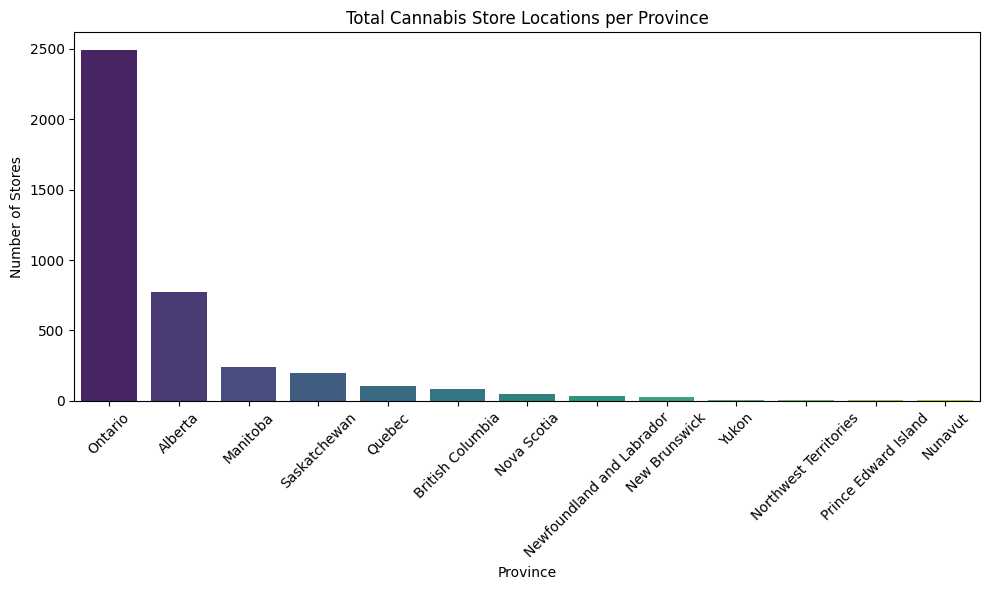

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

# Calculate store counts by province
province_counts = master_df['FullProvinceName'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=province_counts.index, y=province_counts.values, palette="viridis")
plt.title('Total Cannabis Store Locations per Province')
plt.xlabel('Province')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('province_store_counts.png') # Save figure for display

# Print the counts
print("Total locations for each province:")
print(province_counts)

In [28]:
!pip install geopandas

/tmp/ipykernel_13/2086303287.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


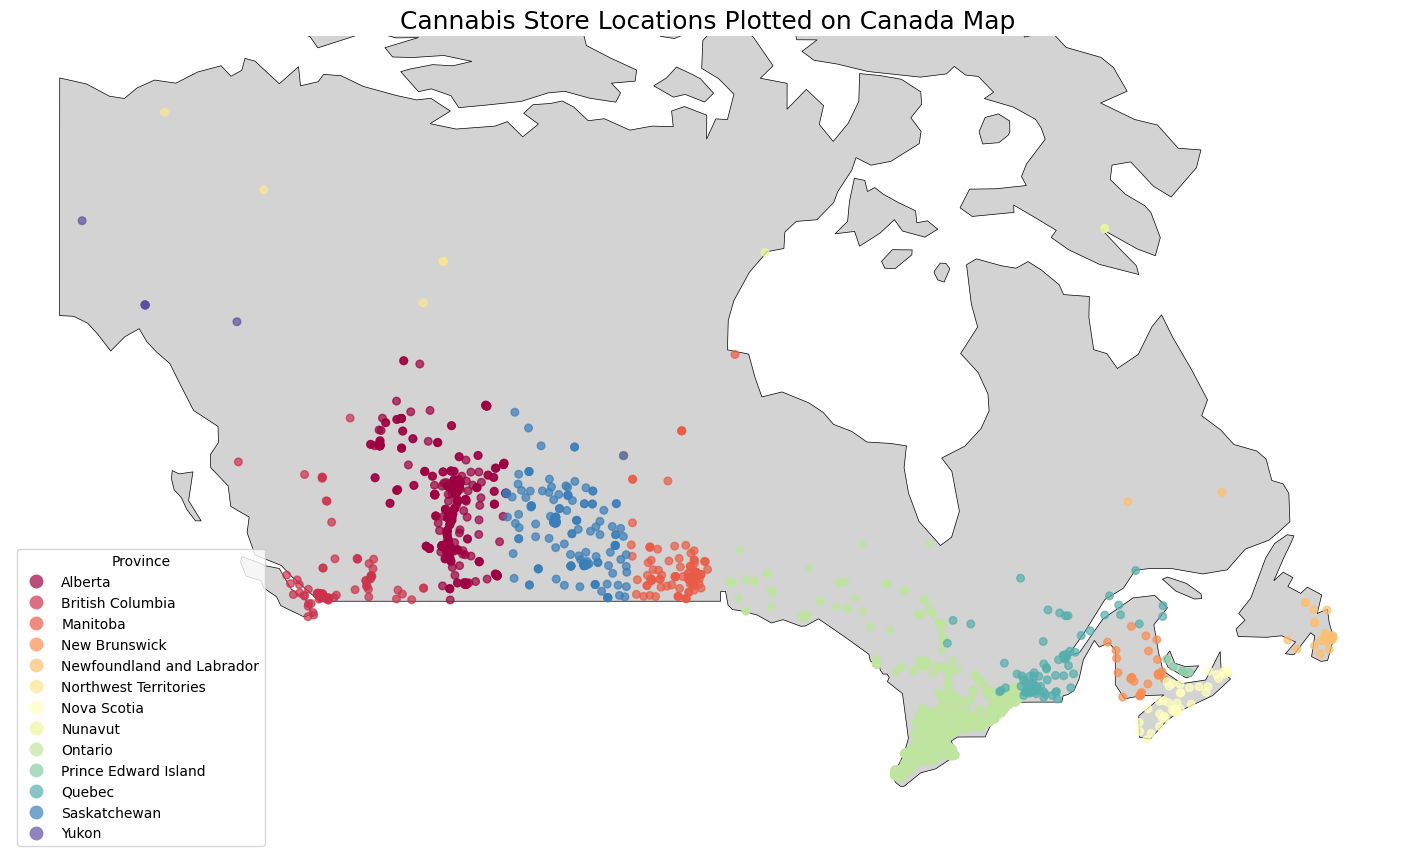

In [29]:
import geopandas
from shapely.geometry import Point

# Ensure Lat/Lon columns are numeric before creating geometry
master_df['Latitude'] = pd.to_numeric(master_df['Latitude'], errors='coerce')
master_df['Longitude'] = pd.to_numeric(master_df['Longitude'], errors='coerce')


# --- 1. Load the Map Borders (GeoPandas) ---
try:
    # Load the world map
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    
    # Filter for Canada's borders
    canada_borders = world[world.name == 'Canada'].copy()
    
    # --- 2. Convert Your Store Data to a GeoDataFrame ---
    # Create a geometry column from Latitude and Longitude
    geometry = [Point(xy) for xy in zip(master_df.Longitude, master_df.Latitude)]
    
    # Create the GeoDataFrame
    gdf_stores = geopandas.GeoDataFrame(
        master_df, 
        geometry=geometry,
        crs=canada_borders.crs # Use the same CRS as the map borders
    )

    # --- 3. Plotting the Map ---
    fig, ax = plt.subplots(1, 1, figsize=(18, 15))
    
    # Plot 1: The Canada map (background)
    canada_borders.plot(
        ax=ax, 
        color='lightgray', 
        edgecolor='black',
        linewidth=0.5
    )
    
    # Plot 2: The Store locations (foreground), colored by province
    gdf_stores.plot(
        ax=ax, 
        marker='o', 
        column='FullProvinceName', # Color points by province
        cmap='Spectral', # A good color map for categorical data
        markersize=30, 
        legend=True,
        legend_kwds={'loc': 'lower left', 'title': 'Province'},
        alpha=0.7
    )
    
    ax.set_title('Cannabis Store Locations Plotted on Canada Map', fontsize=18)
    ax.set_xlim(master_df['Longitude'].min() - 5, master_df['Longitude'].max() + 5)
    ax.set_ylim(master_df['Latitude'].min() - 3, master_df['Latitude'].max() + 3)
    ax.set_axis_off() 
    
    plt.show()

except Exception as e:
    print(f"\nFATAL ERROR: Could not generate map. This usually means the GeoPandas library or its required map data failed to load.")
    print(f"Error details: {e}")

In [ ]:
# =============================================================================
# FINAL OUTPUT
# =============================================================================
master_df.to_csv("../../data/02_processed_data/01_store_locations/CannabisStoreLocations.csv", index=False)